# Basic usage of the cosmoDC2 extragalactic catalog and photoz add-on catalog - Weak gravitational lensing shear by dark matter halo

Owner : Constantin Payerne

#### This notebook can be run at NERSC or CC-IN2P3 where the DESC DC2 products are stored. You need to be a DESC member to be able to access those.

This notebook will show how to use the photometric redshift (photo-z) add-on columns of cosmoDC2 extragalactic catalog in order to estimate the average excess surface density around cluster.

After going through this notebook, you should be able to:

- #### 1. load a cosmoDC2 dark matter halo catalog,

- #### 2. load and access the cosmoDC2 extragalctic catalog,

- #### 3. load and access the cosmoDC2 photo-z add-on columns,

- #### 4. Compute the excess surface density estimator using photometric redshift catalogs.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.integrate
from astropy.table import Table, join
os.environ['CLMM_MODELING_BACKEND'] = 'ccl' # here you may choose ccl, nc (NumCosmo) or ct (cluster_toolkit)
import clmm 
import healpy

In [2]:
import GCRCatalogs

A detailled GitHub repository with multiple example the use of GCRCatalogs is available at https://github.com/LSSTDESC/DC2-analysis/tree/master/tutorials.

# 1. Prepare a dark matter halo from cosmoDC2

Here, we load the cosmoDC2 exctragalactic catalog (small version)

In [3]:
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In order to speed up the extraction of cosmoDC2 data, we select a dark matter halo within a specified healpix pixel available in `cosmoDC2_v1.1.4_small`. The user can change the selected healpix pixel by modifying the quantity `index_healpix_pixels_selected` below.

In [4]:
healpix_pixels = extragalactic_cat.get_catalog_info()['healpix_pixels']

For example,

In [5]:
index_healpix_pixels_selected = 6

In [6]:
healpix_selected = healpix_pixels[index_healpix_pixels_selected]
print('The selected healpix pixel is ' + str(healpix_selected))

The selected healpix pixel is 9942


We extract the dark matter halo catalog for this specified healpix pixel, and applying some property cut (here, mass and redshift range). We select the most massive one in the recovered 
sample.

In [7]:
%time
# get list of massive halos in a given redshift and mass range

mmin = 1.e14 # Msun
zmin = 0.1
zmax = 0.4
massive_halos = extragalactic_cat.get_quantities(['halo_mass','hostHaloMass','redshift','ra', 'dec', 'halo_id'],
                                                 filters=[f'halo_mass > {mmin}','is_central==True',
                                                          f'redshift>{zmin}', f'redshift<{zmax}'], native_filters=['healpix_pixel == ' + str(healpix_selected)])
N_halo = len(massive_halos['halo_mass'])

print(f'There are {N_halo} clusters in this mass and redshift range')

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 27.2 µs
There are 18 clusters in this mass and redshift range


In [8]:
select = massive_halos['halo_mass'] == np.max(massive_halos['halo_mass'])
ra_halo = massive_halos['ra'][select][0]
dec_halo = massive_halos['dec'][select][0]
z_halo = massive_halos['redshift'][select][0]
mass_halo =massive_halos['halo_mass'][select][0]
id_halo = massive_halos['halo_id'][select][0]

In [9]:
print (f'The most massive cluster has ID {id_halo}')
print(f'the halo is in ra = {ra_halo:.2f} deg, dec = {dec_halo:.2f} deg, with redshift = {z_halo:.2f} and mass = {mass_halo:.2e} Msun')

The most massive cluster has ID 135700142421
the halo is in ra = 63.29 deg, dec = -39.65 deg, with redshift = 0.19 and mass = 1.24e+15 Msun


# 2. Extract cosmoDC2 galaxy catalog

The galaxy shapes and true redshifts are available in the cosmoDC2 extragalaxtic catalog, and their photometric related inforamtions are available separetly in add-on columns. We first extract the galaxies within an aperture of 0.6 degrees arround the cluster position, and with magnitude cut `mag_i < 25`.

### Apply coordinates, redshift and magnitude cuts to select backgroud galaxies around the cluster

In [10]:
ra_min, ra_max = ra_halo - 0.3, ra_halo + 0.3
dec_min, dec_max = dec_halo - 0.3, dec_halo + 0.3
mag_i_max = 25

#### We extract the weak lensing quantities for each background galaxies:
- complex shear components `'shear_1'` & `'shear_2'`
- intrinsic ellipticity components `'ellipticity_1_true'` & `'ellipticity_2_true'`
- convergence `'convergence'`
- redshift, sky location

In [11]:
%%time
coord_filters = ['ra >= {}'.format(ra_min),'ra < {}'.format(ra_max),'dec >= {}'.format(dec_min),'dec < {}'.format(dec_max)]

z_filters = ['redshift >= 0']

mag_filters = ['mag_i < {}'.format(mag_i_max)]

extragalactic_cat = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_image", config_overwrite=dict(healpix_pixels=[healpix_selected]))

gal_cat = extragalactic_cat.get_quantities(['galaxy_id', 
                                            'ra', 'dec',
                                            'shear_1', 'shear_2', 
                                            'ellipticity_1_true', 'ellipticity_2_true',
                                            'redshift', 'convergence', 'halo_id'],
                                            filters=(coord_filters + z_filters + mag_filters), 
                                          )

print(str(len(gal_cat['galaxy_id'])) +' loaded galaxies')

40823 loaded galaxies
CPU times: user 6.8 s, sys: 4.52 s, total: 11.3 s
Wall time: 12.1 s


We then compute the obseved galaxy ellipticities using the shear, the convergence and the intrinsic ellipticity for each saved galaxy, where we use the functionalities of the `CLMM` library for cosmology (arXiv:2107.10857). 

The lensed ellipticity writes for a single galaxy

$$
\epsilon^{\rm obs} =
        \frac{\epsilon^{\rm int} + g}{1 + g^*\epsilon^{\rm int}},$$ where the reduced shear expresses as $$g = \frac{\gamma}{1-\kappa}.$$

In [12]:
gal_cat['e1'] = clmm.utils.compute_lensed_ellipticity(gal_cat['ellipticity_1_true'], 
                                                      gal_cat['ellipticity_2_true'], 
                                                      gal_cat['shear_1'], gal_cat['shear_2'], 
                                                      gal_cat['convergence'])[0]

gal_cat['e2'] = clmm.utils.compute_lensed_ellipticity(gal_cat['ellipticity_1_true'], 
                                                      gal_cat['ellipticity_2_true'], 
                                                      gal_cat['shear_1'], 
                                                      gal_cat['shear_2'], 
                                                      gal_cat['convergence'])[1]

In [13]:
#rename the redshift column
gal_cat['z'] = gal_cat['redshift']

In [14]:
gal_cat = Table(gal_cat)

#### We create the member galaxy catalog for the selected cluster, by applying cut on the halo ID,

In [15]:
member_gal_catalog = gal_cat[gal_cat['halo_id'] == id_halo]

# 3. Extract photoz informations

The full details of the photo-z add-on catalog `'cosmoDC2_v1.1.4_small_with_photozs_v1'` are given in the notebook https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/extragalactic_gcr_photoz_catalogs.ipynb edited by Sam Schmidt. This catalog contains photometric redshifts that were computed with the BPZ template-based code (https://ui.adsabs.harvard.edu/abs/2000ApJ...536..571B/abstract). The catalog `'cosmoDC2_v1.1.4_small_with_photozs_flexzboost_v1'` have photozs from FleXZBoost machine learning code (https://arxiv.org/abs/2001.03621). In this notebook we present a method for the estimation of the excess surface density using BPZ photometric redshifts. 

#### We extract for each background galaxies in the above sample:
- the probability density function `'photoz_pdf'`,
- the mean photometric redshift `'photoz_mean'`.

Let's note that the add-on catalog does not support geometrical cut (in `ra`, `dec`, `redshift`). We first extract the photo-z informations in the corresponding healpix pixel, we then match with the cosmoDC2 galaxy sample.

In [16]:
%%time
extragalactic_photoz_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small_with_photozs_v1')
z_bins = extragalactic_photoz_cat.photoz_pdf_bin_centers

CPU times: user 1.04 s, sys: 493 ms, total: 1.54 s
Wall time: 2.71 s


In [17]:
%%time
photoz_cat = extragalactic_photoz_cat.get_quantities(['photoz_pdf','photoz_mean','redshift', 'galaxy_id'], native_filters=['healpix_pixel=='+str(healpix_selected)])

CPU times: user 2.64 s, sys: 5.88 s, total: 8.52 s
Wall time: 9.2 s


In [18]:
photoz_cat_astropy = Table()
photoz_cat_astropy['galaxy_id'] = photoz_cat['galaxy_id']
photoz_cat_astropy['photoz_pdf'] =  photoz_cat['photoz_pdf']
photoz_cat_astropy['photoz_mean'] =  photoz_cat['photoz_mean']

In [19]:
cat_complete = join(photoz_cat_astropy, gal_cat, keys = 'galaxy_id')

For each galaxies, we calculate the probability of being in the background of the cluster, i.e. of having a redshift $>z_{\rm halo} + \delta$, where delta is a positive value we choose to be 0.1. 

For each galaxy, we compute $$p_i = \int_{z_{\rm halo} + \delta}^{+\infty} dz\ p_{\rm photoz, i}(z)$$ where $p_{\rm photoz, i}$ is the photometric redshift probability density function for the galaxy $i$.

In [20]:
delta = 0.1
z_min = z_halo + delta

In [21]:
axis_select_background = [0 if z_bins[i] < z_min else 1 for i in range(len(z_bins))]

In [22]:
m = np.zeros([len(cat_complete), len(z_bins)])
for i in range(len(cat_complete)):
    m[i,:] = np.array(cat_complete['photoz_pdf'][i])

In [23]:
integral_pdf_behind = scipy.integrate.simps(m * axis_select_background, x = z_bins, axis = 1)
norm_pdf = scipy.integrate.simps(m, x = z_bins, axis = 1)

In [24]:
cat_complete['background_probability'] = integral_pdf_behind/norm_pdf
cat_complete['photoz_pdf_norm'] = norm_pdf

In [25]:
member_gal_photoz_catalog = cat_complete[np.isin(cat_complete['galaxy_id'],member_gal_catalog['galaxy_id'])]

## Background source selection

We discuss briefly the effect of redhsift selection of background galaxies, that is affected by the contamination of 'fake' background galaxies i.e. galaxies with true redshift below the halo redshift, but identified as background redshift due to specific cut on photometric information. In the same way, member galaxies can be identified as background galaxies. To test 2 different selection cuts, we consider 3 different cases:
- ##### `cat_true`: cut on true galaxy redshift $z_{\rm cosmoDC2} > z_{\rm l} + \delta$ (identifying true background galaxies).
- ##### `cat_photoz`: cut on mean photoz galaxy redshift $\langle z \rangle_{\rm photoz} > z_{\rm l} + \delta$,
- ##### `cat_probability`: cut on background probability $\int_{z_{\rm halo} + \delta}^{+\infty} dz\ p_{\rm photoz, i}(z)  > 0.95$.

In [26]:
cat_true = cat_complete[cat_complete['redshift'] > z_min]
cat_photoz = cat_complete[cat_complete['photoz_mean'] > z_min]
cat_probability = cat_complete[cat_complete['background_probability'] > 0.95]

#### We check the contamination of member galaxies by counting the member galaxies and also the foreground galaxies in each dataset:

In [27]:
print('====cat_true====')
member_gal_true = len(cat_true[np.isin(cat_true['galaxy_id'],member_gal_catalog['galaxy_id'])])
fraction_member_true = 100*member_gal_true/len(cat_true)
print(f'member : {member_gal_true} ({fraction_member_true:.2f} %)')
foreground_gal_true = len(cat_true['redshift'][cat_true['redshift'] < z_halo])
fraction_foreground_true = 100*foreground_gal_true/len(cat_true)
print(f'foreground : {foreground_gal_true} (fraction {fraction_foreground_true:.2f} %)')
print(' ')
print('====cat_photoz====')
member_gal_photoz = len(cat_photoz[np.isin(cat_photoz['galaxy_id'],member_gal_catalog['galaxy_id'])])
fraction_member_photoz = 100*member_gal_photoz/len(cat_photoz)
print(f'member : {member_gal_photoz} ({fraction_member_photoz:.2f} %)')
foreground_gal_photoz = len(cat_photoz['redshift'][cat_photoz['redshift'] < z_halo])
fraction_foreground_photoz = 100*foreground_gal_photoz/len(cat_photoz)
print(f'foreground : {foreground_gal_photoz} (fraction {fraction_foreground_photoz:.2f} %)')
print(' ')
print('====cat_probability====')
member_gal_probability = len(cat_probability[np.isin(cat_probability['galaxy_id'],member_gal_catalog['galaxy_id'])])
fraction_member_probability = 100*member_gal_probability/len(cat_probability)
print(f'member : {member_gal_probability} ({fraction_member_probability:.2f} %)')
foreground_gal_probability = len(cat_probability['redshift'][cat_probability['redshift'] < z_halo])
fraction_foreground_probability = 100*foreground_gal_probability/len(cat_probability)
print(f'foreground : {foreground_gal_probability} (fraction {fraction_foreground_probability:.2f} %)')

====cat_true====
member : 0 (0.00 %)
foreground : 0 (fraction 0.00 %)
 
====cat_photoz====
member : 26 (0.07 %)
foreground : 713 (fraction 1.85 %)
 
====cat_probability====
member : 0 (0.00 %)
foreground : 33 (fraction 0.10 %)


#### From the count of contamination in each data set, we can see that the background galaxy selection based on mean photometric redshift induces a larger fraction of true foreground galaxies and halo member galaxies in the galaxy sample. 

As a recap, we show in the figure below the different true redshift dataset involved:
- the true redshift histogram in the selected healpix (orange)

- the true redshift histogram in the `cat_true` dataset (dashed red)

- the true redshift histogram in the `cat_photoz` dataset (blue)

- the true redshift histogram in the `cat_probability` dataset (green dashed)

- the individual photoz-pdf of each member galaxies (grey)

In [28]:
pdf_member_galaxy_average = 0
for i, pdf in enumerate(member_gal_photoz_catalog['photoz_pdf']):
    pdf_member_galaxy_average = pdf_member_galaxy_average + pdf/member_gal_photoz_catalog['photoz_pdf_norm'][i]

(array([ 109.,  328.,  493., 1567., 1154., 1425., 1345., 1073., 1607.,
       1539., 1662., 1660., 1851., 1319., 2024., 2940., 1612., 2219.,
       1515., 2157., 1516., 1224., 1110.,  938., 1116.,  870.,  852.,
        383.,  397.,  291.,  318.,  488.,  240.,  217.,  156.,  108.,
        120.,  146.,   84.,  168.,   97.,   24.,   38.,   38.,   59.,
         27.,   29.,   48.,   46.,   12.,   12.,   24.,   14.,    9.,
          4.]), array([0.        , 0.05454545, 0.10909091, 0.16363636, 0.21818182,
       0.27272727, 0.32727273, 0.38181818, 0.43636364, 0.49090909,
       0.54545455, 0.6       , 0.65454545, 0.70909091, 0.76363636,
       0.81818182, 0.87272727, 0.92727273, 0.98181818, 1.03636364,
       1.09090909, 1.14545455, 1.2       , 1.25454545, 1.30909091,
       1.36363636, 1.41818182, 1.47272727, 1.52727273, 1.58181818,
       1.63636364, 1.69090909, 1.74545455, 1.8       , 1.85454545,
       1.90909091, 1.96363636, 2.01818182, 2.07272727, 2.12727273,
       2.18181818, 2.236363

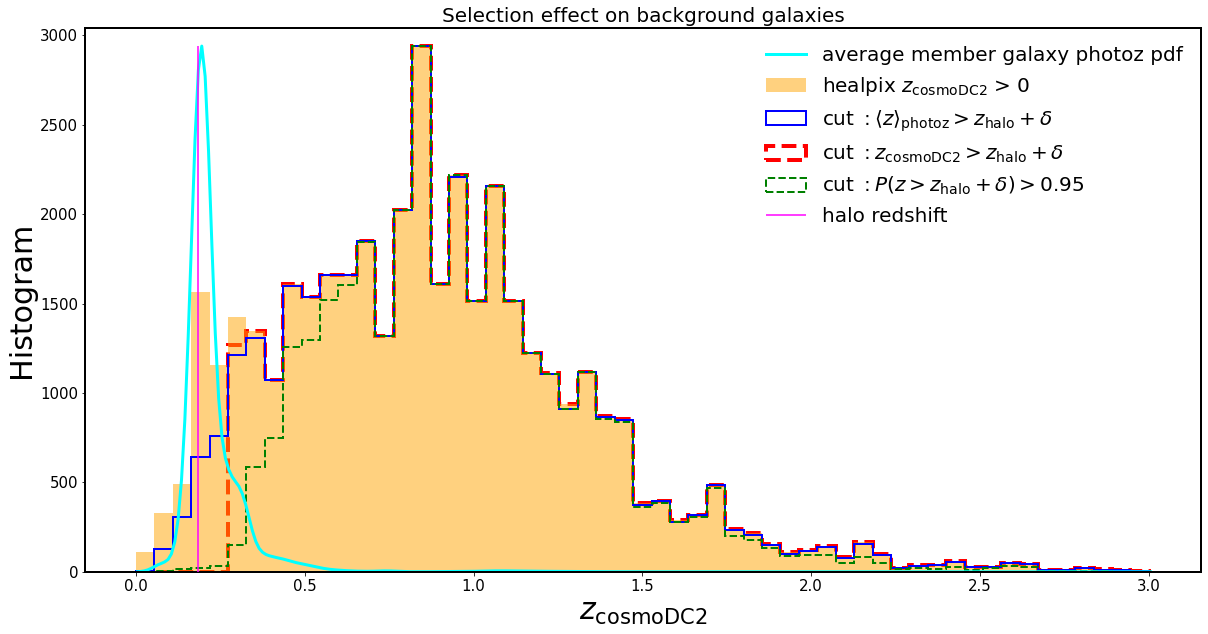

In [29]:
plt.figure(figsize = (20,10))
plt.rcParams['axes.linewidth'] = 2
bins = np.linspace(0, 3, 56)
plt.tick_params(axis='both', which = 'both', labelsize= 15)
hist = plt.hist(gal_cat['redshift'], bins = bins, linewidth = 1, label = r'healpix $z_{\rm cosmoDC2}$ > 0',  color = 'orange', alpha = 0.5)
print(hist)
plt.hist(cat_photoz['redshift'], bins = bins, histtype = 'step', linewidth = 2, label = r'cut $: \langle z \rangle_{\rm photoz} > z_{\rm halo} + \delta$', color = 'b')
plt.hist(cat_true['redshift'], bins = bins, linewidth = 4, histtype = 'step', label = r'cut $: z_{\rm cosmoDC2}  > z_{\rm halo} + \delta$',color = 'r', linestyle = '--', zorder = 0)
plt.hist(cat_probability['redshift'], bins = bins, linewidth = 2, histtype = 'step', label = r'cut $: P(z > z_{\rm halo} + \delta)  > 0.95$',color = 'g', linestyle = '--')
plt.vlines(z_halo, 0, max(hist[0].flatten()), color = 'magenta', linestyle = '-', label = 'halo redshift', zorder = 1000)
pdf = pdf_member_galaxy_average/len(member_gal_photoz_catalog)
plt.plot(z_bins, max(hist[0].flatten())*pdf/max(pdf), 'cyan', label = 'average member galaxy photoz pdf', linewidth = 3)

plt.ylim(0, max(hist[0].flatten())+ 100)
plt.legend(frameon = False, fontsize = 20)
plt.xlabel(r'$z_{\rm cosmoDC2}$', fontsize = 30)
plt.ylabel(r'Histogram', fontsize = 30)
plt.title('Selection effect on background galaxies', fontsize = 20)
plt.show()

# 4. Compute the excess surface density

### Estimator of the excess surface density

- The maximum likelihood estimator of the excess surface density in the radial bin $[R, R + \Delta R[$ is defined by (ref)

$$\widehat{\Delta\Sigma}_+(R) = \frac{1}{\sum\limits_{s = 1} w_{s}}
     \sum\limits_{s= 1}w_{s}\langle\Sigma_{{\rm crit}}(z_s, z_l)^{-1}\rangle^{-1}\epsilon_+^{s},$$ where $\epsilon_+^{s}$ is the tangential ellipticity of the background galaxy with index $s$ (as source) relative to the dark matter halo position with index $l$ (as lens).
     
- The critical surface mass density expresses as $\Sigma_{{\rm crit}}(z_s, z_l) = \frac{c^2}{4 \pi G} \frac{D_A(z_s)}{D_A(z_l) D_A(z_s, z_l)}$, where $D_A(z_l), D_A(z_s)$ are respectively the angular diameter distance to the lens and to the source in physical units, and $D_A(z_s, z_l)$ is the angular diameter distance between the lens and the source.


- The average $\langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle$ is defined as $\langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle = \int_{z_l + \delta}^{+\infty} d z_s\ p_{\rm photoz,s}(z_s)\ \Sigma_{\rm crit}(z_s,z_l)^{-1}$, where $p_{\rm photoz,s}$ is the photometric probability density function for the background galaxy with index $s$.

### Weights $w_s$

The quantities $w_{s}$ are the weights that maximise the sigmnal-to-noise ratio of the excess surface density estimator. They downweight the galaxies that are close in redshift to the cluster (where the lensing signal is weak). They include the lack of informations on both redshift and shape reconstruction for each background galaxies. 

- In the case where there is no error on the shape measurement (for the purpose of cosmoDC2 galaxies), the weight writes $w_{s} = \langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle^{2}$,

- In the case of true redshift $z_s$, the PDF reduces to a Dirac function centered at $z_s$, giving the average $\langle\Sigma_{\rm crit}(z_l,z_s)^{-1}\rangle = \Sigma_{\rm crit}(z_l,z_s)^{-1} $ and the weight $w_{s} = \Sigma_{\rm crit}(z_s,z_l)^{-2}$,


#### We compute the excess surface density in 3 different cases:

- using true backgroud galaxy redshift : $w_{ls}^{\rm true} = \Sigma_{\rm crit}(z_{\rm cosmoDC2},z_l)^{-2}$

- using photometric probability density function : $w_{ls}^{\rm pdf} = \langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle^{2}$

- using mean photometric redshift $w_{ls}^{\rm mean} = \Sigma_{\rm crit}(\langle z \rangle_{\rm photoz},z_l)^{-2}$

- using random sample redshift from the photoz pdf : $w_{ls}^{\rm mean} = \Sigma_{\rm crit}( z_{\rm random},z_l)^{-2}$

In [30]:
cosmo = clmm.Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)

In [31]:
sigma_crit_1 = np.array(1/cosmo.eval_sigma_crit(z_min, z_bins))

In [32]:
m = np.zeros([len(cat_complete), len(z_bins)])

In [33]:
for i in range(len(cat_complete)):
    m[i,:] = np.array(cat_complete['photoz_pdf'][i])

In [34]:
unormed_integral = scipy.integrate.simps(m * sigma_crit_1, x = z_bins, axis = 1)
norm = scipy.integrate.simps(m, x = z_bins, axis = 1)

In [35]:
ws_pdf = (unormed_integral/norm)**2
ws_true = ( 1. /cosmo.eval_sigma_crit(z_min, cat_complete['redshift']) )**2
ws_mean = ( 1. /cosmo.eval_sigma_crit(z_min, cat_complete['photoz_mean']) )**2

In [36]:
ws_random = []
for pdf in cat_complete['photoz_pdf']:
    ws_random.append(np.random.choice(1./cosmo.eval_sigma_crit(z_min, z_bins), p = pdf/np.sum(pdf))**2)
ws_random = np.array(ws_random)

#### We plot the probability $p_{s} = \frac{w_{s}}{\sum_{s'} w_{s'}}$ in each case.

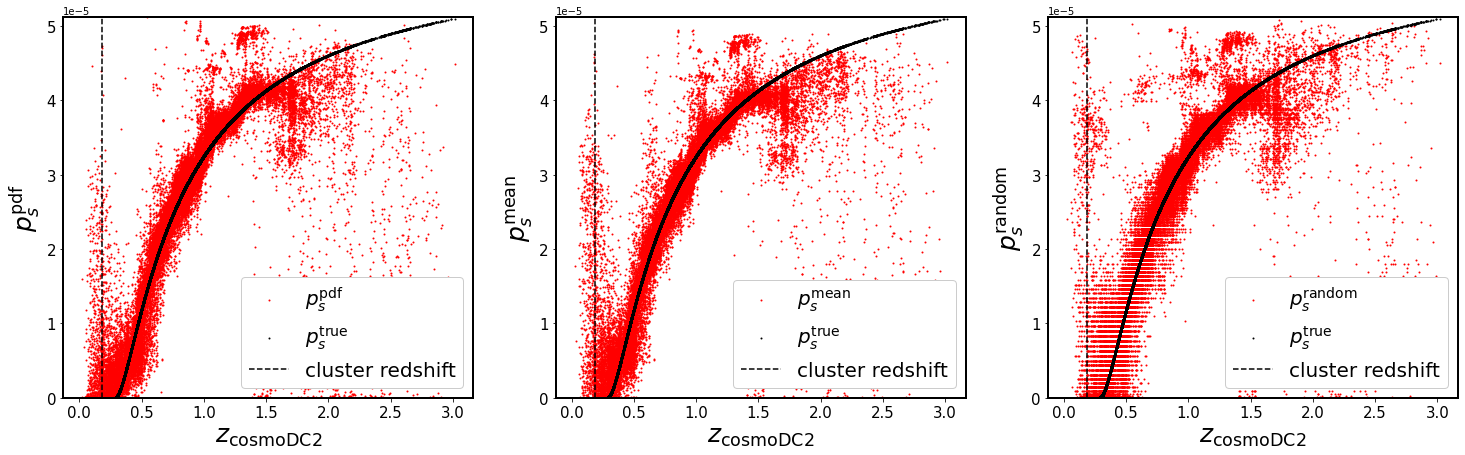

In [37]:
ws_with_photozs = [ws_pdf, ws_mean, ws_random]
label = [r'$p_{s}^{\rm pdf}$', 
         r'$p_{s}^{\rm mean}$', 
         r'$p_{s}^{\rm random}$']
title = []

x = np.linspace(0, 7, 100)
fig, axs = plt.subplots(1, 3, figsize = (25,7))
for i in range(3):
    
    axs[i].scatter(cat_complete['redshift'], ws_with_photozs[i]/np.sum(ws_with_photozs[i]), s = 1, c = 'r', label = label[i])
    axs[i].scatter(cat_complete['redshift'], ws_true/np.sum(ws_true), s = 1, c = 'k', label = r'$p_{s}^{\rm true}$')
    axs[i].vlines(z_halo, 0, 1, color = 'k', linestyle = '--', label = 'cluster redshift', zorder = 1000)
    axs[i].set_ylabel(label[i], fontsize = 25)
    axs[i].set_xlabel(r'$z_{\rm cosmoDC2}$', fontsize = 25)
    axs[i].tick_params(axis='both', which = 'major', labelsize= 15, zorder = 0)
    axs[i].legend(fontsize = 20, loc = 'lower right', frameon = True, framealpha = 1)
    axs[i].set_ylim(0,max(ws_with_photozs[0]/np.sum(ws_with_photozs[0])))

For the thee cases using photoz, the weights $p_s$ scatter arround the black curves below $z \approx 1.5$, beyond this redshift, the eccurences of catastrophic photometric redshift reconstruction increases and the deviation to the black lines is larger.

In [38]:
cat_complete['ws_true'] = np.array(ws_true)
cat_complete['ws_pdf'] = np.array(ws_pdf)
cat_complete['ws_mean'] = np.array(ws_mean)
cat_complete['ws_random'] = np.array(ws_random)

In [39]:
data_complete = clmm.GCData(cat_complete)
cl_complete = clmm.GalaxyCluster('DM_halo', ra_halo, dec_halo, z_halo, data_complete)

We compute the tangential ellipticity for each background galaxy relative to the dark matter halo center (we use the `CLMM` package)

In [40]:
cl_complete.compute_tangential_and_cross_components(
                                    shape_component1='e1', shape_component2='e2', 
                                    tan_component='shear_t', cross_component='shear_x',
                                    geometry="flat")

cl_complete.galcat['r'] = cosmo.eval_da(cl_complete.z)*cl_complete.galcat['theta']

We create a galaxy catalog `cl_true` with background selection on the true redshift. This is the ideal situation where there is no mis-identification of background gaalxies.

In [41]:
data_true = clmm.GCData(cl_complete.galcat[cl_complete.galcat['redshift'] > z_min])
cl_true = clmm.GalaxyCluster('DM_halo', ra_halo, dec_halo, z_halo, data_true)

#### To compute the excess surface density,

- We define a set of bin edges,

- We compute the average excess surface density in each bins as described above,

- We compute the errorbars as the standard deviation in each bin.

In [42]:
bin_edges = clmm.make_bins(0.5,  8, nbins=10, method='evenlog10width')
radial_bin = [[bin_edges[i], bin_edges[i + 1]] for i in range(len(bin_edges)-1)]

In [43]:
def make_radial_profile(catalog = 1, radius = '', tangential_ellipticity = '', weight = '', radial_bin = 1):

    profile = Table(names=['r', 'DS', 'DS_err'])
    
    for i, r_bin in enumerate(radial_bin):
        
        mask = (catalog.galcat[radius] > r_bin[0])*(catalog.galcat[radius] <= r_bin[1])*(catalog.galcat[weight] != 0)

        data_cut = catalog.galcat[mask]
        
        if len(data_cut) == 0:
            
            profile.add_row([r_mean, None, None])
            
            continue
        
        r_mean = np.mean(data_cut['r'])

        ds = np.average(data_cut[tangential_ellipticity]*data_cut[weight]**(-0.5), 
                             weights = data_cut[weight])
        
        #We compute the standard deviation of the excess surface density
        
        ds_rms = np.sqrt(np.average((data_cut['shear_t']*data_cut[weight]**(-0.5) - ds)**2, 
                                         weights = data_cut[weight]))/np.sqrt(len(data_cut))

        profile.add_row([r_mean, ds, ds_rms])
        
    return profile

## Contamination effect

We create two catalogs based on the 2 different background galaxy selection criteria:
- `cl_photoz` with cut :  $\langle z \rangle > z_{\rm halo} + \delta$
- `cl_prpbability` with cut : $P(z > z_{\rm halo} + \delta)  > 0.95$

In [44]:
data_photoz = clmm.GCData(cl_complete.galcat[cl_complete.galcat['photoz_mean'] > z_min])
cl_photoz = clmm.GalaxyCluster('DM_halo', ra_halo, dec_halo, z_halo, data_photoz)

In [45]:
data_probability = clmm.GCData(cl_complete.galcat[cl_complete.galcat['background_probability'] > 0.95])
cl_probability = clmm.GalaxyCluster('DM_halo', ra_halo, dec_halo, z_halo, data_probability)

In [46]:
def contamination(catalog = 1, radius = '', radial_bin = 1):
    
    #Evaluate the contamination from member galaxies and foreground galaxies.

    profile = Table(names=['r', 'count_foreground', 'count_member'])
    
    for i, r_bin in enumerate(radial_bin):
        
        mask_foreground = (catalog.galcat['redshift'] < z_halo)
        
        mask_radius = (catalog.galcat[radius] > r_bin[0])*(catalog.galcat[radius] <= r_bin[1])

        data_cut = catalog.galcat[mask_radius]
        
        if len(data_cut) == 0:
            
            profile.add_row([r_mean, None, None])
            
            continue
        
        data_cut_foreground = catalog.galcat[mask_radius*mask_foreground]
        
        r_mean = np.mean(data_cut['r'])
        
        data_member = catalog.galcat['galaxy_id'][mask_radius][np.isin(catalog.galcat['galaxy_id'][mask_radius],member_gal_catalog['galaxy_id'])]

        profile.add_row([r_mean, len(data_cut_foreground)/len(data_cut), len(data_member)/len(data_cut)])
        
    return profile

We check the contamination of member galaxies and foreground galaxies in each dataset

In [47]:
radial_middle = np.mean(radial_bin, axis = 1)

contamination_photoz = contamination(catalog = cl_photoz, radius = 'r', 
                                  radial_bin = radial_bin)

contamination_probability = contamination(catalog = cl_probability, radius = 'r', 
                                  radial_bin = radial_bin)

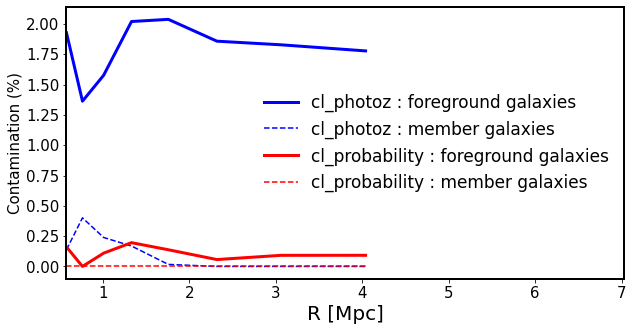

In [48]:
plt.figure(figsize = (10,5))
plt.rcParams['axes.linewidth'] = 2
plt.tick_params(axis='both', which = 'both', labelsize= 15)
plt.plot(radial_middle, 100*contamination_photoz['count_foreground'],'b', label = 'cl_photoz : foreground galaxies', linewidth = 3)
plt.plot(radial_middle,  100*contamination_photoz['count_member'],'--b', label = 'cl_photoz : member galaxies')
plt.plot(radial_middle, 100*contamination_probability['count_foreground'],'r', label = 'cl_probability : foreground galaxies', linewidth = 3)
plt.plot(radial_middle,  100*contamination_probability['count_member'],'--r', label = 'cl_probability : member galaxies')
plt.xlim(min(radial_middle),max(radial_middle))
plt.xlabel('R [Mpc]', fontsize = 20)
plt.ylabel(f'Contamination (%)', fontsize = 15)
plt.legend(frameon = False, fontsize = 17, loc = 'best')
plt.show()

As mentionned in $3. The background galaxy selection is more efficient when selecting galaxies on their probabilities to be in the background of the halo. As excpected, the contamination from meber galaxies decreases with the radius, since the contamination of foreground galaxies is roughly constant with R.

We now plot the excess surface density profile for the 3 galaxy catalogs, using the weight $w^{\rm pdf}_{ls}$ for each galaxy.

In [49]:
weight_name = 'ws_pdf'

In [50]:
#true redhift
profile_true = make_radial_profile(catalog = cl_true, radius = 'r', 
                                   tangential_ellipticity = 'shear_t', 
                                   weight = weight_name, 
                                   radial_bin = radial_bin)

profile_photoz = make_radial_profile(catalog = cl_photoz, radius = 'r', 
                                  tangential_ellipticity = 'shear_t', 
                                  weight = weight_name, 
                                  radial_bin = radial_bin)

profile_probability = make_radial_profile(catalog = cl_probability, radius = 'r', 
                                  tangential_ellipticity = 'shear_t', 
                                  weight = weight_name, 
                                  radial_bin = radial_bin)

We use the CLMM DESC code to compute the 'fiducial' excess surface mass density, by using a NFW profile with halo mass equals to the halo mass provided by cosmoDC2. We choose a concentration of 4.

In [51]:
cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.27-0.045, Omega_b0=0.045, Omega_k0=0.0)
moo = clmm.Modeling(massdef='mean', delta_mdef=200, halo_profile_model='nfw')
moo.set_cosmo(cosmo)
moo.set_concentration(4)
moo.set_mass(mass_halo)
r = np.logspace(np.log10(0.5), np.log10(10), 100)
DeltaSigma = moo.eval_excess_surface_density(r, z_halo)

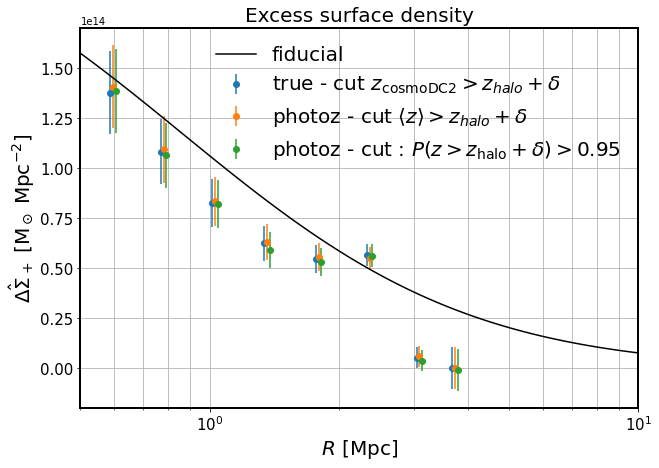

In [52]:
ylabel = r'$\hat{\Delta\Sigma}_+$ ' +'$[$' + r'${\rm M}$' + r'$_\odot\;$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$'
xlabel = r'$R\ [$' + r'${\rm Mpc}$' + r'$]$'
plt.figure(figsize = (10,7))
plt.grid(True, which="both", ls="-")
plt.rcParams['axes.linewidth'] = 2
plt.tick_params(axis='both', which = 'both', labelsize= 15)
deltalogr = 0.03
dr = deltalogr*profile_true['r']

plt.errorbar(profile_true['r']   + 0*dr, profile_true['DS']   , profile_true['DS_err']   , fmt = ' ', marker = 'o', label = r'true - cut $z_{\rm cosmoDC2} > z_{halo} + \delta$')
plt.errorbar(profile_photoz['r']   + 0.5*dr, profile_photoz['DS']   , profile_photoz['DS_err']   , fmt = ' ', marker = 'o', label = r'photoz - cut $\langle z \rangle > z_{halo} + \delta$')
plt.errorbar(profile_probability['r']   +1*dr, profile_probability['DS']   , profile_probability['DS_err']   , fmt = ' ', marker = 'o', label = r'photoz - cut : $P(z > z_{\rm halo} + \delta)  > 0.95$')
plt.plot(r, DeltaSigma,'-k', label = 'fiducial')
plt.xscale('log')
plt.xlim(min(r),max(r))
#plt.ylim(-0.2e14,0.8e14)
plt.xlabel(xlabel, fontsize = 20)
plt.ylabel(ylabel, fontsize = 20)
plt.legend(frameon = False, fontsize = 20, loc = 'upper right')
plt.title('Excess surface density', fontsize = 20)
plt.show()